In [2]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import calendar
import time
from matplotlib import colors
from sklearn import preprocessing
import cartopy.crs as crs
import cartopy.feature as cfeature
import scipy

from src import get_corrs
from src import format_error_df
from src import plot_heatmaps
from src import read_nwp_data

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
init = "12"

(
    gfs_fcast_and_error_df,
    nam_fcast_and_error_df,
    hrrr_fcast_and_error_df,
) = read_nwp_data.read_data(init)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [5]:
lulc = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/aspect_hrrr.csv")
lulc = lulc.drop(columns=["site", "station"])
keys = [
    "No Slope",
    "East:Low",
    "SW:Low",
    "NW:Low",
    "West:Low",
    "SE:Low",
    "South:Low",
    "NE:Low",
    "NE:Medium",
]

In [6]:
lulc.keys()

Index(['19', '23', '26', '28', '27', '24', '25', '22', '32'], dtype='object')

In [7]:
months_df = format_error_df.format_df(hrrr_fcast_and_error_df)

In [8]:
months_df

,time,station,t2m_error
0,1,ADDI,0.488205
1,1,ANDE,-0.375797
2,1,BATA,0.153479
3,1,BEAC,0.320778
4,1,BELD,0.082270
...,...,...,...
1507,12,WFMB,0.519461
1508,12,WGAT,1.070140
1509,12,WHIT,0.958491
1510,12,WOLC,0.144420


# HRRR

In [9]:
(
    df_pers,
    df_rho,
    df_tau,
    df_p_score,
    df_p_score_rho,
    df_p_score_tau,
) = get_corrs.get_corrs(months_df, lulc, keys)

/home/aevans/nwp_bias/src/correlation/hrrr/../src/get_corrs.py:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/home/aevans/nwp_bias/src/correlation/hrrr/../src/get_corrs.py:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/home/aevans/nwp_bias/src/correlation/hrrr/../src/get_corrs.py:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/home/aevans/nwp_bias/src/correlation/hrrr/../src/get_corrs.py:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/home/aevans/nwp_bias/src/correlation/hrrr/../src/get_corrs.py:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lul

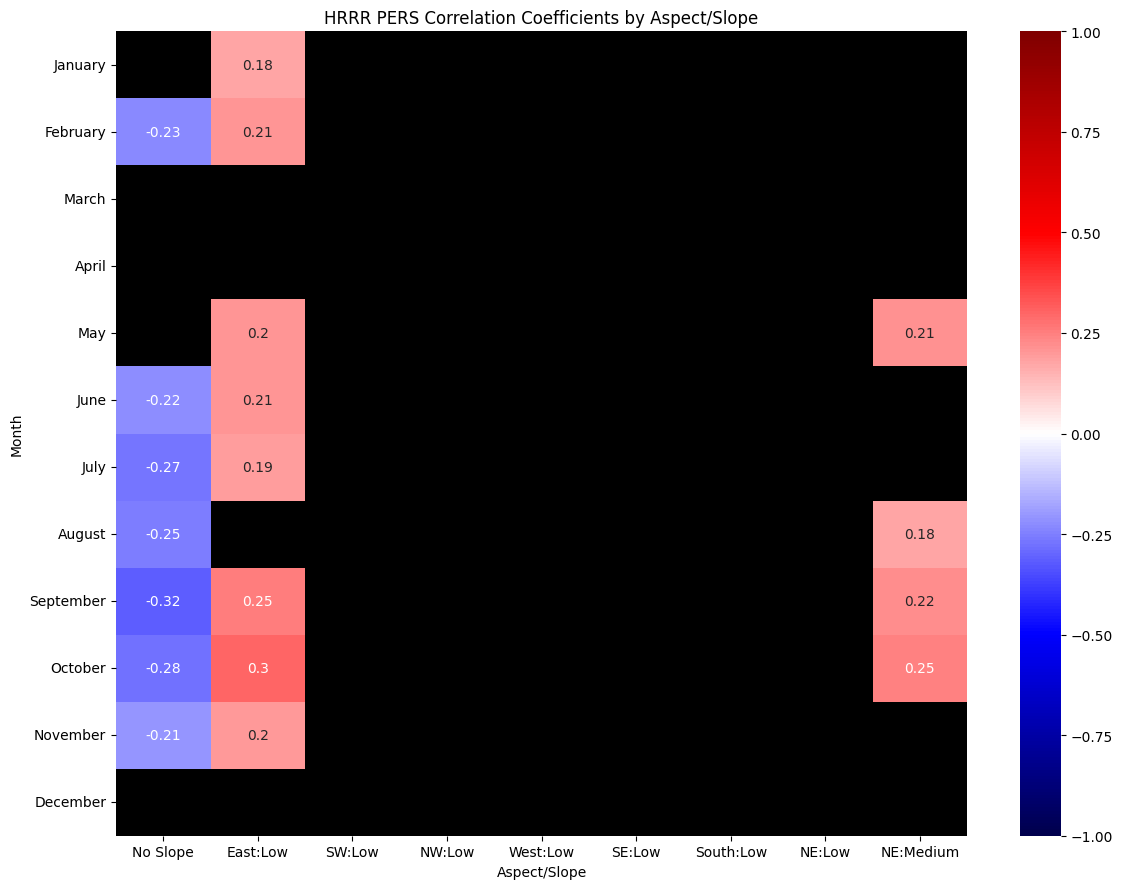

In [10]:
plot_heatmaps.plot_heatmap_corrs(df_pers, "PERS", "Aspect/Slope", "HRRR")

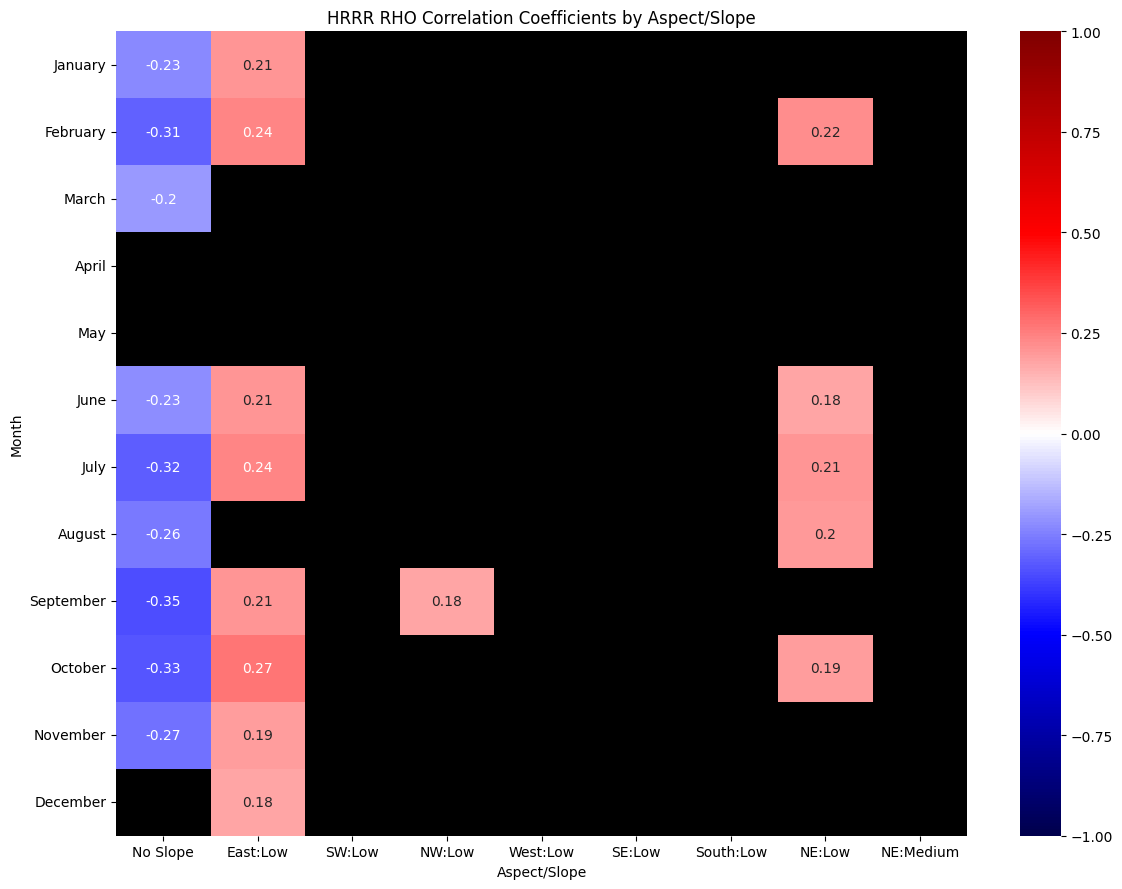

In [11]:
plot_heatmaps.plot_heatmap_corrs(df_rho, "RHO", "Aspect/Slope", "HRRR")

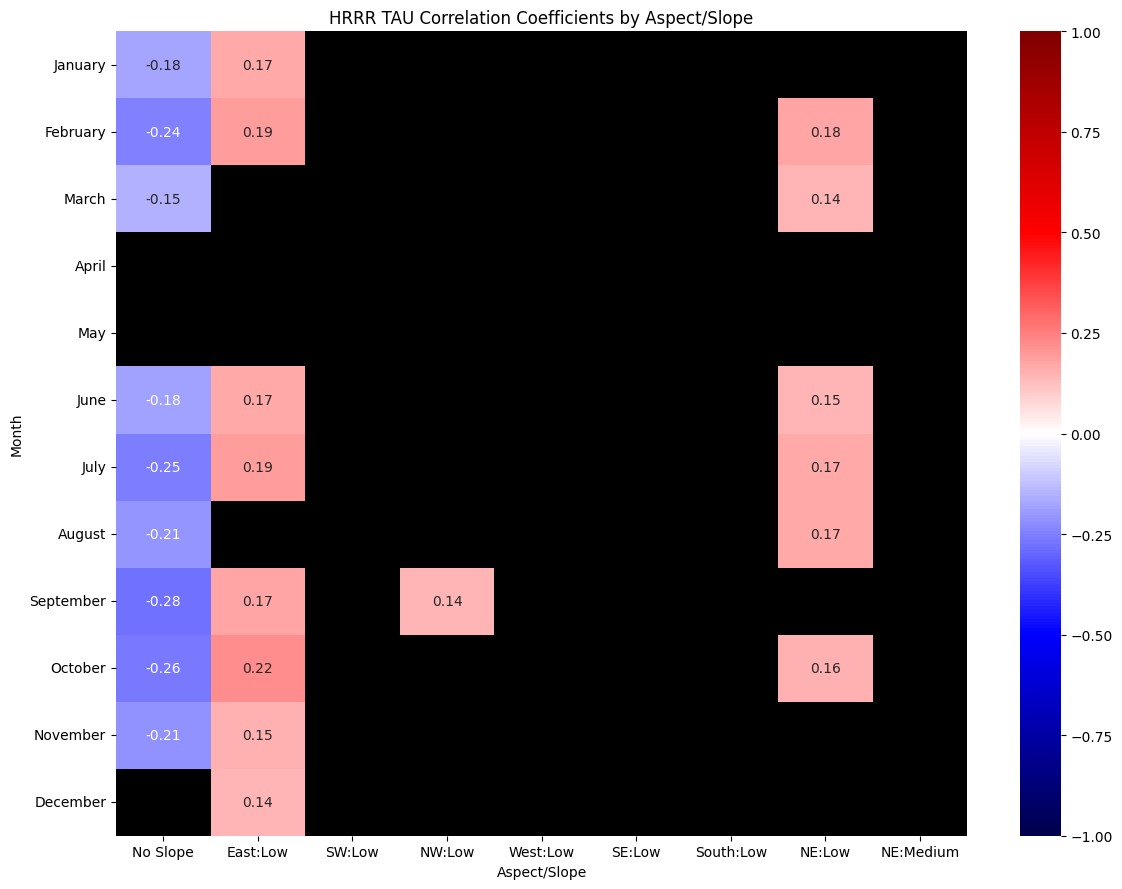

In [12]:
plot_heatmaps.plot_heatmap_corrs(df_tau, "TAU", "Aspect/Slope", "HRRR")